In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 비지도 학습

오늘날 대부분의 머신러닝 애플리케이션은 대부분 지도학습기반

-> 사용할 수 있는 데이터는 대부분 레이블이 없음 (입력 특성 $X$ 만 있고 레이블 $y$ 는 없음).

* 지능 = 케이크,
* 비지도 학습 = 케이크의 빵, 
* 지도 학습 = 케이크의 크림, 
* 강화 학습 = 케이크 위의 체리

---

8장에서 배운 차원축소(비지도 학습), 이번 장에는 알고리즘.

* 군집 :  비슷한 샘플을 클러스터로 모은다. 

  데이터 분석, 고객 분류, 추천 시스템, 검색 엔진, 이미지 분할, 준지도 학습, 차원 축소 등에 사용

* 이상치 탐지 : 정상 데이터가 어떻게 보이는지를 학습하고 비정상 샘플을 감지하는데 사용, 
  
  제조 결함 감지나 시계열 데이터에서 새로운 트렌드 찾기

* 밀도 추정 : 데이터셋 생성 확률 과정의 확률 밀도 함수(PDF)를 추정. 

  이상치 탐지에도 사용. 데이터 분석, 시각화

## 군집

비슷한 샘플을 구별해 하나의 클러스터 또는 비슷한 샘플의 그룹으로 할당하는 작업 -> 군집

[9-1]을 보면 왼쪽 데이터셋은 레이블이 존재하고 오른쪽은 동일한 데이터셋이지만 레이블이 없음.

대부분의 군집 알고리즘은 왼쪽아래 클러스터를 쉽게 감지할 수 있으나

오른쪽 위의 클러스터를 2개의 하위 클러스터로 나눈 것은 쉽지 않음.

사실 이 데이터셋은 그림에 없는 2개의 특성(꽃받침의 높이와 너비) 이 더 있음.

모든 특성을 사용한다면 군집 알고리즘이 더 잘 분류할 수 있음.

In [2]:
from sklearn.datasets import load_iris

data = load_iris()
X = data.data
y = data.target
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

그림 저장: [9-1] classification_vs_clustering_plot


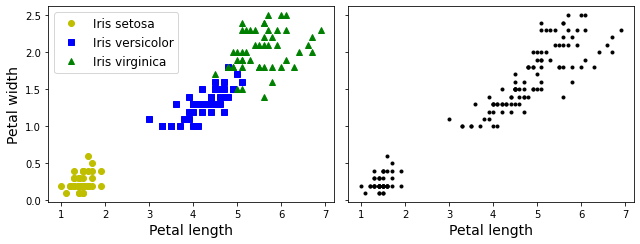

In [3]:
plt.figure(figsize=(9, 3.5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal length", fontsize=14)
plt.tick_params(labelleft=False)

save_fig("[9-1] classification_vs_clustering_plot")
plt.show()

군집 알고리즘의 사용 예시

* 고객 분류: 고객을 구매 이력이나 웹사이트 내 행동 등을 기반으로 클러스터. 추천 시스템

* 데이터 분석: 데이터셋을 분석할 때 군집 알고리즘을 실행하고 각 클러스터를 따로 분석

* 차원 축소 기법: 각 클러스터에 대한 샘플의 친화성을 측정. 각 샘플의 특성 벡터 x는 
  
  클러스터 친화성의 벡터로 바꿀 수 있다. 원본 특성 벡터보다 저차원

* 이상치 탐지: 모든 클러스터에 친화성이 낮은 샘플은 이상치일 가능성이 높다. 부정 거래 감지에 활용

* 준지도 학습: 레이블된 샘플이 적을 때 군집을 수행하고 동일한 클러스터에 있는 모든 샘플에 레이블을 전파

* 검색 엔진: 제시된 이미지와 비슷한 이미지를 찾아준다.\

* 이미지 분할: 색을 기반으로 픽셀을 클러스터로 모으고 각 픽셀의 색을 해당 클러스터의 평균 색으로    

  변환하며 이미지 색상의 종류를 줄인다. 물체의 윤곽 감지하기 쉬워져 물체 탐지 및 추적시스템에 사용

클러스터에 대한 보편적인 정의의는 없으나 실제상황마다 다름.

알고리즘이 다르면 다른 종류의 클러스터를 감지. 

어떤 알고리즘은 센트로이드라 부르는 특정포인트를 중심으로 모인 샘플을 찾는다.

또 다른 알고리즘은 샘플이 밀집되어 연속인 영역을 찾는다.

그리고 어떤 알고리즘은 계층적으로 클러스터의 클러스터를 찾는다.

(아래에서 설명할) 가우시안 혼합 모델은 3개의 클러스터를 잘 나눌 수 있습니다

(꽃잎 길이와 너비, 꽃받침 길이와 너비 4개의 특성을 모두 사용합니다).

In [4]:
from sklearn.mixture import GaussianMixture

y_pred = GaussianMixture(n_components=3, random_state=42).fit(X).predict(X)

각 클러스터를 하나의 클래스에 매핑해보죠. 이 매핑을 (책에서처럼) 하드 코딩하는 대신 

(`scipy.stats.mode()` 함수를 사용해) 각 클러스터에서 가장 많은 클래스를 선택합니다:

In [5]:
from scipy import stats

mapping = {}
for class_id in np.unique(y):
    mode, _ = stats.mode(y_pred[y==class_id])
    mapping[mode[0]] = class_id

mapping

{1: 0, 2: 1, 0: 2}

In [6]:
y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred])

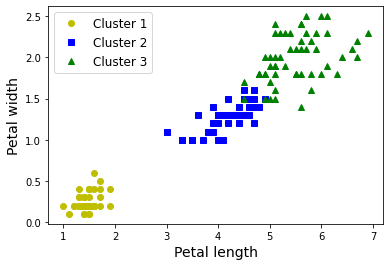

In [7]:
plt.plot(X[y_pred==0, 2], X[y_pred==0, 3], "yo", label="Cluster 1")
plt.plot(X[y_pred==1, 2], X[y_pred==1, 3], "bs", label="Cluster 2")
plt.plot(X[y_pred==2, 2], X[y_pred==2, 3], "g^", label="Cluster 3")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

In [8]:
np.sum(y_pred==y)

145

In [9]:
np.sum(y_pred==y) / len(y_pred)

0.9666666666666667

**노트**: 사이킷런 알고리즘이 이따금 업데이트되기 때문에 이 노트북의 결과가 책과 조금 다를 수 있습니다.

### k-평균

[9-2]와 같이 레이블이 없는 데이터셋을 생각해봅시다. 샘플 덩어리 5개가 눈에 띔.

k-평균은 반복 몇 번으로 이런 종류의 데이터셋을 빠르고 효율적으로 클러스터로 묶을 수 있음.

먼저 예제 데이터를 생성:

In [10]:
from sklearn.datasets import make_blobs

blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

In [11]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

그림 저장: [9-2] blobs_plot


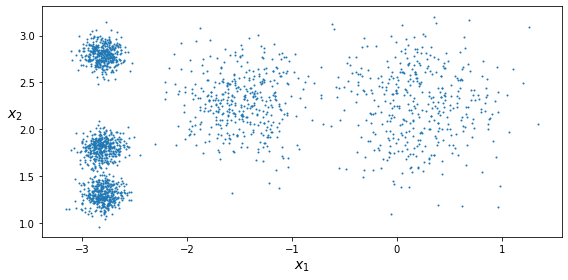

In [12]:
plt.figure(figsize=(8, 4))
plot_clusters(X)
save_fig("[9-2] blobs_plot")
plt.show()

이 데이터셋으로 k-평균 알고리즘을 훈련해보죠. 이 알고리즘은 각 클러스터의 중심을 찾고 

가장 가까운 클러스터에 샘플 할당.

In [13]:
from sklearn.cluster import KMeans

k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

알고리즘이 찾을 클러스터 수 $k$ 를 지정. 뒤에서 k를 지정하는 게 왜 어려운지 알아볼 예정.

각 샘플은 5개의 클러스터 중 하나에 할당됨. 군집에서 각 샘플의 레이블은 

알고리즘이 샘플에 할당한 클러스터의 인덱스. 분류에서 클래스 레이블과 혼동해선 안 됨!

In [14]:
y_pred

array([4, 0, 1, ..., 2, 1, 0])

In [15]:
y_pred is kmeans.labels_

True

이 알고리즘이 찾은 센트로이드 5개도 확인할 수 있음.

In [16]:
kmeans.cluster_centers_

array([[-2.80389616,  1.80117999],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80037642,  1.30082566]])

`KMeans` 객체는 훈련한 샘플의 레이블을 가지고 있습니다. 

조금 혼동스럽지만 여기에서 샘플의 _레이블_ 은 샘플에 할당한 클러스터의 인덱스.

In [17]:
kmeans.labels_

array([4, 0, 1, ..., 2, 1, 0])

새로운 샘플에 가장 가까운 센트로이드의 클러스터를 할당할 수 있음.

물론 새로운 샘플의 레이블을 예측할 수 있음:

In [18]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([1, 1, 2, 2])

클러스터의 결정경계를 그려보면 보로노이 다이어그램을 얻을 수 있음.

센트로이드는 x로 표시되어 있음.

In [19]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12, 
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

그림 저장: [9-3] voronoi_plot


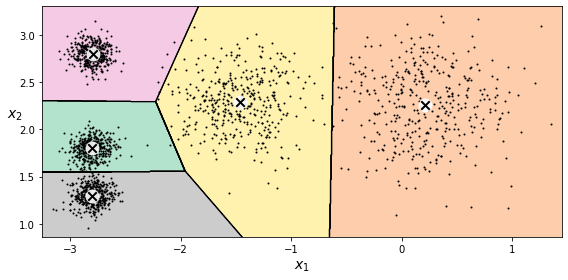

In [20]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
save_fig("[9-3] voronoi_plot")
plt.show()

샘플 몇 개는 레이블이 잘못 부여됨 (특히 왼쪽 위에 있는 클러스터와 가운데 클러스터의 경계 부근).

실제 k-평균 알고리즘은 클러스터의 크기가 많이 다르면 잘 작동하지 않음.

-> 샘플을 클러스터에 할당할 때 센트로이드까지 거리를 고려하는 것이 전부이기 떄문

|

하드 군집: 샘플을 하나의 클러스터에 할당

소프트 군집: 클러스터마다 샘플에 점수를 부여
  
(샘플과 센트로이드 사이의 거리, 가우시안 방사 기저 함수와 같은 유사도 점수 등)

KMeans 클래스의 transform() 은 샘플과 각 센트로이드 사이의 거리를 반환

In [21]:
kmeans.transform(X_new)

array([[2.81093633, 0.32995317, 2.9042344 , 1.49439034, 2.88633901],
       [5.80730058, 2.80290755, 5.84739223, 4.4759332 , 5.84236351],
       [1.21475352, 3.29399768, 0.29040966, 1.69136631, 1.71086031],
       [0.72581411, 3.21806371, 0.36159148, 1.54808703, 1.21567622]])

X_new에 있는 첫번째 샘플이 첫번째 센트로이드에서 2.81, 두번째 샘플이 두번째 센트로이드에서 0.32,

세번째 샘플이 세번째 센트로이드에서 2.90, ...거리 만큼 떨어져 있음.

고차원 데이터셋을 이런 방식으로 변환하면 k-차원 데이터셋이 만들어짐.

=> 이 변환은 매우 효율적인 비선형 차원 축소 기법이 될 수 있음.

#### K-평균 알고리즘

K-평균 알고리즘은 가장 빠르고 가장 간단한 군집 알고리즘 중 하나:

* 먼저 $k$ 개의 센트로이드를 랜덤하게 초기화: 데이터셋에서 $k$ 개의 샘플을 랜덤하게 선택하고 센트로이드를 그 위치에 놓음.

* 수렴할 때까지 다음을 반복(즉, 센트로이드가 더이상 이동하지 않을 때까지):
    * 각 샘플을 가장 가까운 센트로이드에 할당.
    * 센트로이드에 할당된 샘플의 평균으로 센트로이드를 업데이트.

`KMeans` 클래스는 기본적으로 최적화된 알고리즘을 적용. 

(교육적인 목적으로) 원래 K-평균 알고리즘을 사용하려면 `init="randome"`, `n_init=1`, 

`algorithm="full"`로 설정해야 합니다. 이 매개변수들은 아래에서 설명.

K-평균 알고리즘을 1, 2, 3회 반복하고 센트로이드가 어떻게 움직이는지 확인:

In [22]:
kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1,
                      algorithm="full", max_iter=1, random_state=0)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1,
                      algorithm="full", max_iter=2, random_state=0)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1,
                      algorithm="full", max_iter=3, random_state=0)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


KMeans(algorithm='full', init='random', max_iter=3, n_clusters=5, n_init=1,
       random_state=0)

#### NOTE_

이 알고리즘의 계산 복잡도는 일반적으로 샘플 수 m, 클러스터 수 k, 차원 개수 n에 선형적

하지만 데이터가 군집할 수 있는 구조를 가질 때. 최악의 경우 샘플의 개수가 지수적으로 급격히 증가.

일반적으로 k-평균은 가장 빠른 군집 알고리즘 중 하나

그림 저장: [9-4] kmeans_algorithm_plot


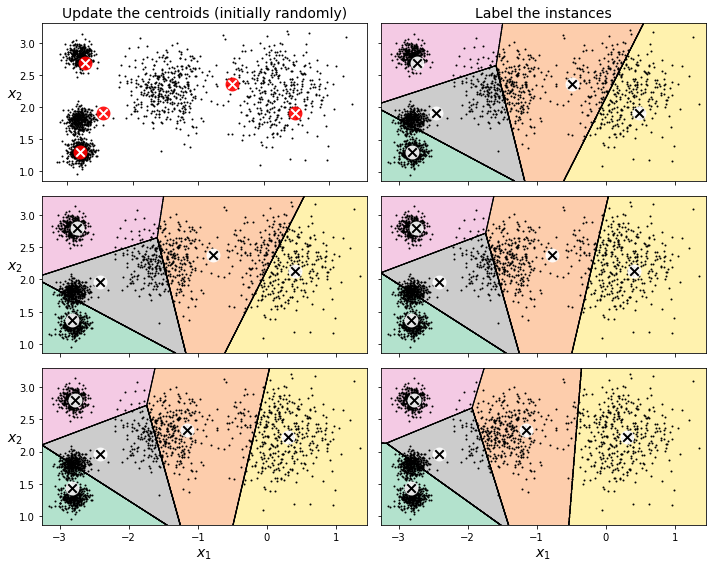

In [23]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

save_fig("[9-4] kmeans_algorithm_plot")
plt.show()

이 알고리즘이 수렴하는 것이 보장되나 적절한 솔루션으로 수렴하지 못할 수 있음

(즉 지역 최적점으로 수렴할 수 있음). 이 여부는 센트로이드 초기화에 달려 있음.

[9-5]는 랜덤 초기화 단계에 운이 없을 때 알고리즘이 수렴할 수 있는 최적이 아닌 솔루션의 두 예.

In [24]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


그림 저장: [9-5] kmeans_variability_plot


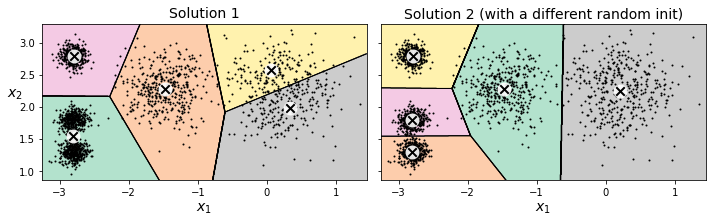

In [25]:
kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1,
                          algorithm="full", random_state=2)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1,
                          algorithm="full", random_state=5)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1", "Solution 2 (with a different random init)")

save_fig("[9-5] kmeans_variability_plot")
plt.show()

센트로이드 초기화를 개선하여 이런 위험을 줄일 수 있는 방법을 알아봅시다.

#### 센트로이드 초기화 방법

1. 센트로이드 위치를 근사하게 알 수 있는 경우 그 위치로 초기화(다른 군집 알고리즘을 먼저 실행)

센트로이드 위치를 근사하게 알 수 있다면 init 매개변수에 센트로이드 리스트를 담은

넘파이 배열을 지정하고 n_init를 1로 설정할 수 있음.

In [26]:
'''
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1)
'''

'\ngood_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])\nkmeans = KMeans(n_clusters=5, init=good_init, n_init=1)\n'

또 다른 방법은 

2. 랜덤 초기화를 다르게 하여 여러번 알고리즘을 실행하고 가장 좋은 솔루션을 선택하는 것. (이너셔 사용)

랜덤 초기화 횟수는 n_init 매개변수로 조절함. default = 10
이는 fit()를 호출할 때 앞서 설명한 전체 알고리즘이 10번 실행된다는 뜻.
사이킷런은 이 중에 최선의 솔루션을 반환. 어떻게 알 수 있을까? 이 때 사용하는 성능 지표가 "이니셔"

#### 이너셔

"이너셔" : 이 값은 각 샘플과 가장 가까운 센트로이드 사이의 평균제곱거리

[9-5]는 왼쪽 모델의 이너셔는 대략 223.3, 오른쪽 모델의 이너셔는 237.5
[9-3]의 모델은 211.6임. KMeans 클래스는 알고리즘을 n_init 번 실행하여 이너셔가 가장 낮은 모델을 반환.
이 예에서는 (랜덤초기화가 운이 나쁘지만 않다면) [9-3]에 있는 모델이 선택될 것.

이 값이 궁금하다면 inertia_ 변수로 모델의 이너셔를 확인할 수 있음.

최선의 모델을 선택하려면 K-평균 모델의 성능을 평가할 방법이 있어야 합니다. 안타깝지만 군집은 비지도 학습이기 때문에 타깃이 없습니다. 하지만 적어도 각 샘플과 센트로이드 사이의 거리는 측정할 수 있습니다. 이것이 _이너셔_ 지표의 아이디어입니다:

In [27]:
kmeans.inertia_

211.59853725816836

score()는 이너셔의 음숫값 반환. 왜냐? 예측기의 score()는 사이킷런의 "큰 값이 좋은 것이다"라는

규칙을 따라야 하기 때문. 한 예측기가 다른 것보다 좋다면 score()가 더 높은 값을 반환해야 함.

In [28]:
kmeans.score(X)

-211.59853725816836

#### ? 다중 초기화

변동성 이슈를 해결하는 한 방법은 단순히 K-평균 알고리즘을 랜덤 초기화를 다르게 하여 여러 번 실행하고 가장 작은 이너셔를 만드는 솔루션을 선택합니다. 예를 들어 앞선 그림에 있는 엉터리 모델 두 개의 이너셔는 다음과 같습니다.

In [29]:
kmeans_rnd_init1.inertia_

219.43539442771407

In [30]:
kmeans_rnd_init2.inertia_

211.5985372581684

여기서 볼 수 있듯이 앞서 훈련한 "좋은" 모델보다 이너셔가 더 높습니다. 즉 더 나쁘다는 것을 의미합니다.

`n_init` 매개변수를 지정하면 사이킷런은 원래 알고리즘을 `n_init` 번 실행하고 이너셔가 가장 작은 솔루션을 선택합니다. 이 매개변수의 기본값은 `n_init=10`입니다.

In [31]:
kmeans_rnd_10_inits = KMeans(n_clusters=5, init="random", n_init=10,
                             algorithm="full", random_state=2)
kmeans_rnd_10_inits.fit(X)

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


KMeans(algorithm='full', init='random', n_clusters=5, random_state=2)

여기에서 볼 수 있듯이 결국 처음 만들었던 모델을 얻었습니다. 이 모델이 최적의 K-평균 결과로 보입니다($k=5$라고 가정하고 이너셔를 기준으로 했을 때입니다).

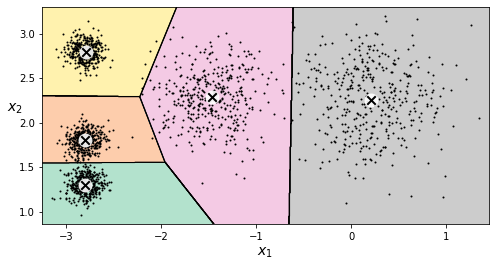

In [32]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_rnd_10_inits, X)
plt.show()

#### k-means++ 알고리즘

다른 센트로이드와 거리가 먼 센트로이드를 선택하는 초기화 단계 이용

센트로이드를 완전히 랜덤하게 초기화하는 대신 David Arthur와 Sergei Vassilvitskii가 [2006년 논문](https://goo.gl/eNUPw6)에서 제안한 다음 알고리즘(k-means++)을 사용해 초기화하는 것이 더 좋습니다:

* 방법 :

1. 데이터셋에서 무작위로 균등하게 하나의 센트로이드 $c_1$을 선택합니다.

2. $D(\mathbf{x}_i)^2$ / $\sum\limits_{j=1}^{m}{D(\mathbf{x}_j)}^2$의 확률로 샘플 $\mathbf{x}_i$를 새로운 센트로이드 $c_i$로 선택합니다. 여기에서 $D(\mathbf{x}_i)$는 샘플 $\mathbf{x}_i$에서 이미 선택된 가장 가까운 센트로이드까지 거리입니다. 이 확률 분포는 이미 선택한 센트로이드에서 멀리 떨어진 샘플을 센트로이드로 선택할 가능성을 높임.

3. $k$ 개의 센트로이드를 선택할 때까지 이전 단계를 반복.

K-평균++ 알고리즘의 나머지는 일반 K-평균과 같습니다. 이 초기화 방식을 사용하면 K-평균 알고리즘이 최적의 솔루션에 수렴할 가능성이 훨씬 높아집니다. 따라서 `n_init` 값을 상당히 줄일 수 있습니다. 대부분의 경우 `n_init`를 줄이는 것이 초기화 과정에 추가된 복잡도를 보상합니다.

KMeans 클래스는 기본적으로 이 초기화방법을 사용함. 원래 방식을 사용하려면

init 매개변수 "random"으로 지정함. 그러나 그럴 필요성은 거의 없을 것

In [33]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)
kmeans.fit(X)
kmeans.inertia_

211.59853725816836

#### k-평균 속도 개선과 미니배치 k-평균

K-평균 알고리즘은 불필요한 거리 계산을 많이 피하는 식으로 속도를 크게 높일 수 있습니다. 
이를 위해 삼각 부등식을 사용합니다(3개의 포인트 A, B, C가 있을 때, 거리 AC는 항상 AC ≤ AB + BC를 만족)
그리고 샘플과 센트로이드 사이 거리의 최솟값과 최댓값을 유지

(자세한 내용은 [2003년 논문](https://www.aaai.org/Papers/ICML/2003/ICML03-022.pdf)참고).

Elkan의 K-평균 방식을 사용하려면 `algorithm="elkan"`으로 설정하세요. 이 방법은 희소 행렬을 지원하지 않습니다. 따라서 사이킷런은 밀집 배열에는 `"elkan"`을 사용하고 희소 행렬에는 (기본 K-평균 알고리즘인) `"full`을 사용합니다.

In [34]:
%timeit -n 50 KMeans(algorithm="elkan", random_state=42).fit(X)

111 ms ± 3.17 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [35]:
'''%timeit -n 50 KMeans(algorithm="full", random_state=42).fit(X)'''
# ㅈㄴ 느려

'%timeit -n 50 KMeans(algorithm="full", random_state=42).fit(X)'

데이터셋이 작기 때문에 여기에서는 큰 차이가 없습니다.

#### 미니배치 K-평균

전체 데이터셋을 사용하지 않고 이 알고리즘은 각 반복마다 미니배치를 사용해 센트로이드를 조금씩 이동.

이는 일반적으로 알고리즘 속도를 3~4배 정도 높임. 대량의 데이터셋에 적용 가능. 일반 k-means보다 빠르지만 이너셔는 일반적으로 조금 나쁨.(특히 클러스터 개수 증가할 때)

In [36]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


MiniBatchKMeans(n_clusters=5, random_state=42)

In [37]:
minibatch_kmeans.inertia_

211.652398504332

데이터셋이 메모리에 다 들어가지 못하면 가장 간단한 방법은 이전 장의 점진적 PCA에서 했던 것처럼 `memmap` 클래스를 사용하는 것입니다. 먼저 MNIST 데이터를 로드합니다:

In [38]:
import urllib.request
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.int64)

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    mnist["data"], mnist["target"], random_state=42)

`memmap`에 데이터를 기록합니다:

In [40]:
filename = "my_mnist.data"
X_mm = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)
X_mm[:] = X_train

minibatch_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10, random_state=42)
minibatch_kmeans.fit(X_mm)

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


MiniBatchKMeans(batch_size=10, n_clusters=10, random_state=42)

데이터가 너무 커서 `memmap`을 사용할 수 없다면 문제는 더 복잡해집니다. 배치를 로드하는 함수를 먼저 만들어 보죠(실전에서는 디스크에서 데이터를 로드합니다):

In [41]:
def load_next_batch(batch_size):
    return X[np.random.choice(len(X), batch_size, replace=False)]

한 번에 하나의 배치를 모델에 주입하여 훈련할 수 있습니다. 또한 여러 번 초기화를 수행하고 이너셔가 가장 낮은 모델을 선택합니다:

In [42]:
np.random.seed(42)

In [43]:
k = 5
n_init = 10
n_iterations = 100
batch_size = 100
init_size = 500  # K-Means++ 초기화를 위해 충분한 데이터 전달
evaluate_on_last_n_iters = 10

best_kmeans = None

for init in range(n_init):
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, init_size=init_size)
    X_init = load_next_batch(init_size)
    minibatch_kmeans.partial_fit(X_init)

    minibatch_kmeans.sum_inertia_ = 0
    for iteration in range(n_iterations):
        X_batch = load_next_batch(batch_size)
        minibatch_kmeans.partial_fit(X_batch)
        if iteration >= n_iterations - evaluate_on_last_n_iters:
            minibatch_kmeans.sum_inertia_ += minibatch_kmeans.inertia_

    if (best_kmeans is None or
        minibatch_kmeans.sum_inertia_ < best_kmeans.sum_inertia_):
        best_kmeans = minibatch_kmeans

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(
C:\Anacond

In [44]:
best_kmeans.score(X)

-211.6257187889114

미니배치 K-평균이 일반 K-평균보다 훨씬 빠릅니다:

In [45]:
%timeit KMeans(n_clusters=5, random_state=42).fit(X)

76.6 ms ± 8.72 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [46]:
%timeit MiniBatchKMeans(n_clusters=5, random_state=42).fit(X)

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

177 ms ± 730 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


*훨씬* 빠르군요! 하지만 성능이 낮은 (즉 이너셔가 높은) 경우가 많습니다. _k_ 가 증가할수록 더 그렇습니다. 미니배치 K-평균과 일반 K-평균 사이에 이너셔와 훈련 시간을 그래프로 나타내 보겠습니다:

In [47]:
from timeit import timeit

times = np.empty((100, 2))
inertias = np.empty((100, 2))
for k in range(1, 101):
    kmeans_ = KMeans(n_clusters=k, random_state=42)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    print("\r{}/{}".format(k, 100), end="")
    times[k-1, 0] = timeit("kmeans_.fit(X)", number=10, globals=globals())
    times[k-1, 1]  = timeit("minibatch_kmeans.fit(X)", number=10, globals=globals())
    inertias[k-1, 0] = kmeans_.inertia_
    inertias[k-1, 1] = minibatch_kmeans.inertia_

1/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows wi

2/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

3/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

4/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

5/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

6/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

7/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

8/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

9/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

10/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

11/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

12/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

13/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

14/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

15/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

16/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

17/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

18/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

19/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

20/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

21/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

22/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

23/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

24/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

25/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

26/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

27/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

28/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

29/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

30/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

31/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

32/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

33/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

34/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

35/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

36/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

37/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

38/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

39/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

40/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

41/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

42/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

43/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

44/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

45/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

46/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

47/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

48/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

49/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

50/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

51/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

52/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

53/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

54/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

55/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

56/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

57/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

58/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

59/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

60/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

61/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

62/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

63/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

64/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

65/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

66/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

67/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

68/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

69/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

70/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

71/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

72/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

73/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

74/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

75/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

76/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

77/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

78/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

79/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

80/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

81/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

82/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

83/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

84/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

85/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

86/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

87/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

88/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

89/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

90/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

91/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

92/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

93/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

94/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

95/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

96/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

97/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

98/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

99/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

100/100

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Anacond

그림 저장: [9-6] minibatch_kmeans_vs_kmeans


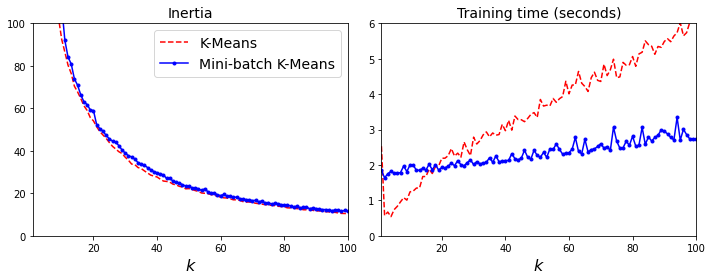

In [48]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(range(1, 101), inertias[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), inertias[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Inertia", fontsize=14)
plt.legend(fontsize=14)
plt.axis([1, 100, 0, 100])

plt.subplot(122)
plt.plot(range(1, 101), times[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), times[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Training time (seconds)", fontsize=14)
plt.axis([1, 100, 0, 6])

save_fig("[9-6] minibatch_kmeans_vs_kmeans")
plt.show()

#### 최적의 클러스터 개수 찾기

지금까지 클러스터 개수를 5로 지정했는데 일반적으로 k를 어떻게 설정할 지 쉽게 알 수 없음.

클러스터 개수가 5보다 작거나 크게 지정하면 어떨까요?

그림 저장: [9-7] bad_n_clusters_plot


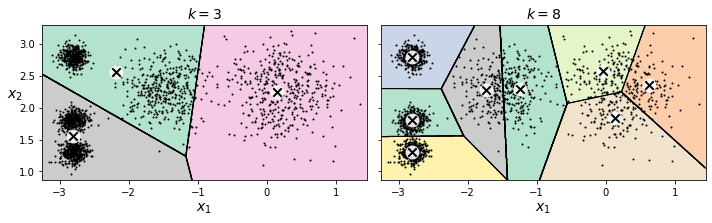

In [49]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
save_fig("[9-7] bad_n_clusters_plot")
plt.show()

가장 작은 이너셔를 가진 모델을 선택하면 되지 않을까? 안타깝게도 그렇게 간단하지 않음.

k=3일때 이너셔는 653.21, k=8일때 이너셔는 119.11, (k=5일 때 이너셔 211.6)

이너셔는 k가 증가함에 따라 점점 작아지므로 k를 선택할 때 좋은 성능지표가 아님.

실제로 클러스터가 늘어날수록 각 샘플은 가가운 센트로이드에 더 가깝게 됨.

따라서 이너셔는 더 작아질 것. 이너셔를 k의 함수로 그래프를 그려봅시다.

In [50]:
kmeans_k3.inertia_

653.2167190021554

In [51]:
kmeans_k8.inertia_

119.11983416102878

In [52]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


그림 저장: [9-8] inertia_vs_k_plot


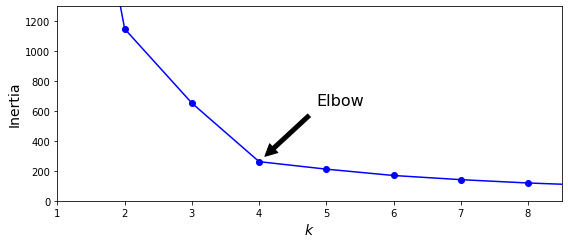

In [53]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
save_fig("[9-8] inertia_vs_k_plot")
plt.show()

이 그래프의 형태만 보면 k=4 지점이 엘보. 따라서 답을 모른다면 4는 좋은 선택이 됨.

이보다 작은 값은 변화가 심하고 큰 값은 크게 도움되지 않음. 

어쩌면 완벽한 클러스터를 아무 이유없이 반으로 나눠버린걸지도 모름.

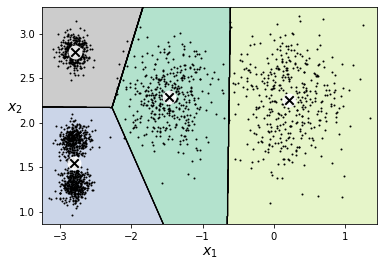

In [54]:
plot_decision_boundaries(kmeans_per_k[4-1], X)
plt.show()

이보다 더 정확한 방법은 실루엣 점수 -> 모든 샘플에 대한 실루엣 계수의 평균.

한 샘플의 실루엣 계수는 $(b - a)/\max(a, b)$. 여기에서 $a$ 는 
같은 클러스터에 있는 다른 샘플까지의 평균 거리(이를 _클러스터 내부 평균 거리_). 

$b$ 는 가장 가까운 클러스터까지 평균 거리. 즉 가장 가까운 클러스터(샘플 자신의 클러스터를 제외하고 $b$를 최소화하는 클러스터)의 샘플까지 평균 거리. 

실루엣 계수는 -1에서 +1 사이 값을 가짐. 

* +1에 가까우면 샘플이 다른 클러스터로부터 떨어져 자신의 클러스터 안에 잘 있다는 것을 의미.
* 0에 가까우면 클러스터 경계에 가깝다는 의미. 
* -1에 가까우면 샘플이 잘못된 클러스터에 할당되었다는 의미.

In [55]:
from sklearn.metrics import silhouette_score

silhouette_score(X, kmeans.labels_)

0.6555176425728279

클러스터 개수를 달리해 실루엣 점수를 비교해봅시다.

In [56]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

그림 저장: [9-9] silhouette_score_vs_k_plot


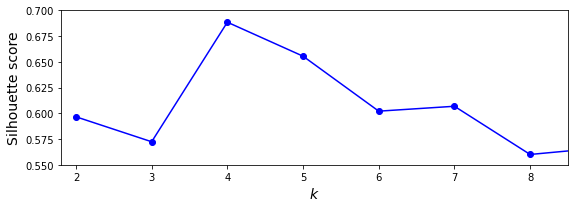

In [57]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
save_fig("[9-9] silhouette_score_vs_k_plot")
plt.show()

여기에서 볼 수 있듯이 이 그래프는 이전보다 정보가 더 풍부합니다. 
특히 $k=4$가 매우 좋은 선택이지만 $k=5$도 꽤 괜찮은 선택이라는 것을 보여줍니다.

모든 샘플의 실루엣 계수를 할당된 클러스터와 실루엣 값으로 정렬하여 

그리면 훨씬 많은 정보를 얻을 수 있습니다. 이를 _실루엣 다이어그램_ 이라고 합니다:

클러스터마다 칼모양의 그래프가 그려지는데, 

이 그래프의 높이는 클러스터가 포함된 샘플의 개수를

이 그래프의 너비는 클러스터에 포함된 샘플의 정렬된 실루엣 계수를 나타냄.

그림 저장: [9-10] silhouette_analysis_plot


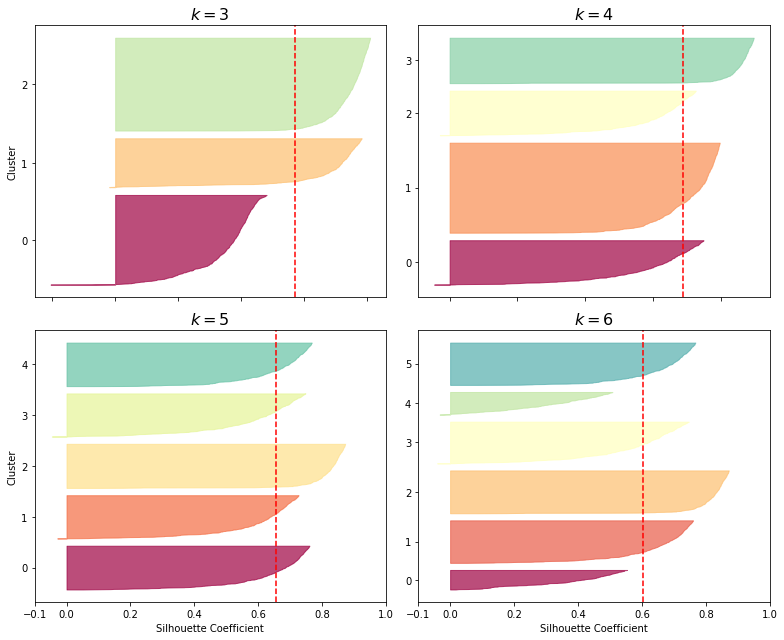

In [58]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

save_fig("[9-10] silhouette_analysis_plot")
plt.show()

여기에서 볼 수 있듯이 $k=5$가 가장 좋은 선택입니다. 

모든 클러스터의 크기가 거의 동일하고 평균 실루엣 점수를 나타내는 파선을 모두 넘었습니다.

### k-평균의 한계

알고리즘을 여러 번 실행해야하고, 클러스터 개수를 지정해야한다. 클러스터의 크기나 밀집도가 서로 다르거나 원형이 아닐 경우 잘 작동하지 않는다.

In [59]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

In [60]:
#plot_clusters(X)

In [61]:
kmeans_good = KMeans(n_clusters=3, init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]), n_init=1, random_state=42)
kmeans_bad = KMeans(n_clusters=3, random_state=42)
kmeans_good.fit(X)
kmeans_bad.fit(X)

KMeans(n_clusters=3, random_state=42)

그림 저장: [9-11] bad_kmeans_plot


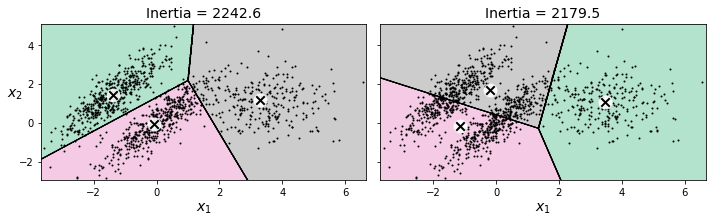

In [62]:
plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title("Inertia = {:.1f}".format(kmeans_good.inertia_), fontsize=14)

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title("Inertia = {:.1f}".format(kmeans_bad.inertia_), fontsize=14)

save_fig("[9-11] bad_kmeans_plot")
plt.show()

[9-11] 여기서 볼 수 있듯이 이 솔루션들은 모두 좋지 않음.

### 군집을 사용한 이미지 분할

이미지 분할은 이미지를 세그먼트 여러개로 분할하는 작업.

예시로 자율주행차의 비전 시스템에서 보행자 이미지를 구성하는 모든 픽셀은 '보행자' 세그먼트에 할당될 것.

이 경우 각 보행자는 다른 세그먼트가 될 수 있음. 여기서는 색상 분할을 해보겠습니다.

시맨틱 또는 인스턴스 분할에서 최고수준의 성능을 내려면 합성곱 신경망을 사용한 복잡한 모델을 사용해야함.

동일 색상을 가진 픽셀을 같은 세그먼트에 할당할 것.

먼저 맷플롭립의 imread()를 사용해 이미지를 읽어보죠

In [63]:
# 무당벌레 이미지를 다운로드합니다
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "unsupervised_learning")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/rickiepark/handson-ml2/master/"
filename = "ladybug.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/unsupervised_learning/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('.\\images\\unsupervised_learning\\ladybug.png',
 <http.client.HTTPMessage at 0x2afb38bf5b0>)

In [64]:
from matplotlib.image import imread
image = imread(os.path.join(images_path, filename))
image.shape

(533, 800, 3)

이 이미지를 3D배열로 표현됨. 첫번째 차원의 크기가 높이, 두번째는 너비, 세번째는 컬러 채널 수.
여기에는 RGB채널(RGB의 강도를 담은 3D 벡터)이 존재 (이 값은 0.0 ~ 1.0 사이).

적은 채널을 가진 이미지 : ex) 흑백이미지
많은 채널을 가진 이미지 : ex) 투명도를 위한 알파채널을 가진 이미지나 위성이미지

다음 코드는 이 배열을 RGB 색상의 긴 리스트로 변환한 다음 k-평균을 사용해 이 색상을 클러스터로 모음.

In [65]:
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8, random_state=42).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

예를 들어 모든 초록색을 하나의 컬러 클러스터로 만들 수 있음.
그다음 각 색상에 대해(ex. 검은초록색) 그 픽셀의 컬러 클러스터의 평균컬러를 찾음.
예로 모든 초록색은 모든 밝은 초록색으로 바뀔 수 있음(초록 클러스터의 평균색이 밝은 초록이라 가정).
마지막으로 이 긴 색상의 리스트를 원본이미지와 동일한 크기로 바꿈.

|

이렇게하면 [9-12]를 출력. 그림처럼 클러스터 개수를 여러개로 바꿔 테스트할 수 있음.
8개보다 클러스터 개수를 작게 하면 무당벌레의 화려한 빨간색이 독자적인 클러스터를 만들지 못하고
주위색에 합쳐짐. 이는 k-평균이 비슷한 크기의 클러스터를 만드는 경향이 있기 때문.
무당벌레는 이미지의 나머지 부분보다 훨씬 작기 때문에 화려한 색을 가지고 있더라도 k-평균이 무당벌레를
하나의 클러스터로 만들지 못함.

In [66]:
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

그림 저장: [9-12] image_segmentation_diagram


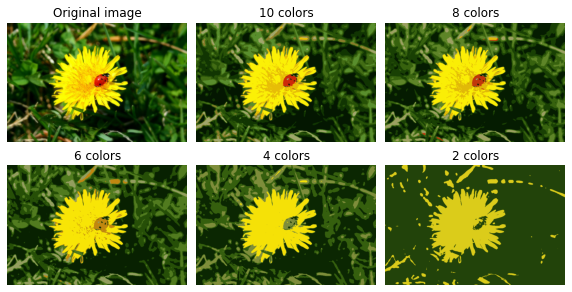

In [67]:
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')

save_fig('[9-12] image_segmentation_diagram', tight_layout=False)
plt.show()

### 군집을 사용한 전처리

MNIST와 유사하게 숫자 0~9까지 8x8 흑백 이미지 1,797개로 이루어진 숫자 데이터셋을 다루어 보겠습니다.

In [68]:
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)

훈련세트와 테스트세트로 나눕니다.

In [69]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)

그다음 로지스틱 회귀모델을 훈련함.

In [70]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

테스트세트에서 정확도를 평가

In [71]:
log_reg_score = log_reg.score(X_test, y_test)
log_reg_score

0.9688888888888889

기본 모델의 정확도는 96.89%. 이제 K-평균을 전처리 단계로 사용해 더 향상할 수 있는지 알아보죠. 
훈련 세트를 50개의 클러스터로 만들고 이미지를 이 클러스터까지 거리로 바꾼 다음 로지스틱 회귀 모델을 적용하는 파이프라인을 만듭니다:

In [72]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50, random_state=42)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)),
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('kmeans', KMeans(n_clusters=50, random_state=42)),
                ('log_reg',
                 LogisticRegression(max_iter=5000, multi_class='ovr',
                                    random_state=42))])

In [73]:
pipeline_score = pipeline.score(X_test, y_test)
pipeline_score

0.9777777777777777

얼마나 오차가 감소했나?

In [74]:
1 - (1 - pipeline_score) / (1 - log_reg_score)

0.28571428571428414

어떤가요? 오차율을 약 30%나 줄였습니다! 하지만 클러스터 개수 $k$를 임의로 결정했습니다. 이 보다 더 나은 방법이 있겠죠. K-평균을 분류 파이프라인에서 전처리 단계로 사용했기 때문에 좋은 $k$ 값을 찾는 것은 이전보다 더 쉽습니다. 실루엣 분석을 수행하거나 이너셔를 최소화할 필요가 없습니다. 가장 좋은 $k$ 값은 가장 좋은 분류 성능을 내는 것입니다.

In [75]:
from sklearn.model_selection import GridSearchCV

param_grid = dict(kmeans__n_clusters=range(90, 100)) # 원래는 2, 100 인데 너무 오래걸려서 줄여버림
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ..............................kmeans__n_clusters=90; total time=   3.7s
[CV] END ..............................kmeans__n_clusters=90; total time=   4.6s
[CV] END ..............................kmeans__n_clusters=90; total time=   3.8s
[CV] END ..............................kmeans__n_clusters=91; total time=   4.5s
[CV] END ..............................kmeans__n_clusters=91; total time=   4.3s
[CV] END ..............................kmeans__n_clusters=91; total time=   4.6s
[CV] END ..............................kmeans__n_clusters=92; total time=   4.0s
[CV] END ..............................kmeans__n_clusters=92; total time=   4.6s
[CV] END ..............................kmeans__n_clusters=92; total time=   3.5s
[CV] END ..............................kmeans__n_clusters=93; total time=   4.5s
[CV] END ..............................kmeans__n_clusters=93; total time=   4.3s
[CV] END ..............................kmeans__n

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..............................kmeans__n_clusters=96; total time=   4.8s
[CV] END ..............................kmeans__n_clusters=97; total time=   4.2s
[CV] END ..............................kmeans__n_clusters=97; total time=   4.7s
[CV] END ..............................kmeans__n_clusters=97; total time=   4.0s
[CV] END ..............................kmeans__n_clusters=98; total time=   4.8s
[CV] END ..............................kmeans__n_clusters=98; total time=   4.6s
[CV] END ..............................kmeans__n_clusters=98; total time=   4.2s
[CV] END ..............................kmeans__n_clusters=99; total time=   4.2s
[CV] END ..............................kmeans__n_clusters=99; total time=   4.8s
[CV] END ..............................kmeans__n_clusters=99; total time=   4.1s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans',
                                        KMeans(n_clusters=50, random_state=42)),
                                       ('log_reg',
                                        LogisticRegression(max_iter=5000,
                                                           multi_class='ovr',
                                                           random_state=42))]),
             param_grid={'kmeans__n_clusters': range(90, 100)}, verbose=2)

In [76]:
print("[+] 최선의 k값 : ", grid_clf.best_params_)
print("[+] 파이프라인 성능 : ", grid_clf.score(X_test, y_test))

[+] 최선의 k값 :  {'kmeans__n_clusters': 95}
[+] 파이프라인 성능 :  0.9777777777777777


### 군집을 사용한 준지도 학습

군집의 또 다른 사용처는 레이블이 없는 샘플이 많고 레이블이 있는 샘플이 적을 때 사용하는 준지도 학습입니다.

레이블을 가진 샘플이 50개만 있을 때 로지스틱 회귀 모델의 성능을 확인해 보죠:

In [77]:
n_labeled = 50

log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", random_state=42)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])
log_reg.score(X_test, y_test)

0.8333333333333334

당연히 이전보다 훨씬 낮네요. 어떻게 더 향상할 수 있는지 알아 보겠습니다. 먼저 훈련 세트를 클러스터 50개로 군집함. 그다음 각 클러스터에서 센트로이드에 가장 가까운 이미지를 찾음. 이 이미지를 대표 이미지라고 부르겠습니다:

In [78]:
k = 50

kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

대표 이미지를 출력하고 수동으로 레이블을 매겨 보겠습니다:

그림 저장: representative_images_diagram


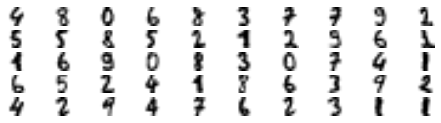

In [79]:
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')

save_fig("representative_images_diagram", tight_layout=False)
plt.show()

In [80]:
y_train[representative_digit_idx]

array([4, 8, 0, 6, 8, 3, 7, 7, 9, 2, 5, 5, 8, 5, 2, 1, 2, 9, 6, 1, 1, 6,
       9, 0, 8, 3, 0, 7, 4, 1, 6, 5, 2, 4, 1, 8, 6, 3, 9, 2, 4, 2, 9, 4,
       7, 6, 2, 3, 1, 1])

In [81]:
y_representative_digits = np.array([
    4, 8, 0, 6, 8, 3, 7, 7, 9, 2,
    5, 5, 8, 5, 2, 1, 2, 9, 6, 1, 
    1, 6, 9, 0, 8, 3, 0, 7, 4, 1, 
    6, 5, 2, 4, 1, 8, 6, 3, 9, 2, 
    4, 2, 9, 4, 7, 6, 2, 3, 1, 1])

이 데이터셋은 레이블이 있는 샘플이 50개뿐이지만 완전히 랜덤한 샘플이 아니라 각 샘플은 클러스터의 대표 이미지입니다. 성능이 더 나은지 확인해 보죠:

In [82]:
# ?? 문제가 있는 것 같음. 9.5% 라고 나옴

log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.9222222222222223

와우! 83.3%에서 92.2%로 확 올랐네요. 여전히 50개의 샘플로만 모델을 훈련했습니다. 샘플에 레이블을 다는 것은 비용이 많이 들고 어려운 작업입니다. 특히 전문가가 수동으로 작업할 때 그렇습니다. 이 때 랜덤한 샘플보다는 대표 샘플에 레이블을 다는 것이 좋은 생각입니다.

하지만 더 향상시킬 수 있습니다. 이 레이블을 같은 클러스터에 있는 다른 모든 샘플에 전파하면 어떨까요?

In [83]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]
    
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train_propagated)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [84]:
# ?? 문제가 있는 것 같음. 15.3% 라고 나옴

log_reg.score(X_test, y_test)

0.9333333333333333

아주 조금 정확도를 높였습니다. 없는 것보다는 낫지만 센트로이드에 가까운 샘플에만 레이블을 전파하는 것이 나을지 모릅니다. 왜냐하면 전체 클러스터에 전파하면 일부 이상치를 포함하기 때문입니다. 

레이블을 센트로이드에 가까운 75번째 백분위수까지만 전파해보죠:

In [85]:
percentile_closest = 75

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

이제 부분적으로 전파한 이 데이터셋에 모델을 다시 훈련해보죠

In [86]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [87]:
log_reg.score(X_test, y_test)

0.9355555555555556

조금 더 낫네요. 레이블된 샘플 50개(클래스당 평균 5개 샘플!)만 가지고 93.6% 성능을 달성했습니다. 레이블된 전체 숫자 데이터셋에서 훈련한 로지스틱 회귀의 성능(96.9%)과 매우 비슷합니다.

이는 전파된 레이블이 실제로 매우 좋기 때문입니다. 이 정확도는 96%에 가깝습니다:

In [88]:
np.mean(y_train_partially_propagated == y_train[partially_propagated])

0.9750747756729811

*능동 학습*을 여러 번 반복할 수 있습니다:
1. 분류기의 확신이 부족한 샘플에 수동으로 레이블을 부여합니다. 가능하면 다른 클러스터에서 샘플을 선택합니다.
2. 추가된 레이블을 사용해 새로운 모델을 훈련합니다.

### DBSCAN

밀집된 연속적 지역을 클러스터로 정의

1) 알고리즘이 각 샘플에서 작은 거리인 ${\epsilon}$ 내에 샘플이 몇 개 놓여 있는지 센다. 

   이 지역을 샘플의 $\epsilon$-이웃이라고 한다.

2) (자신 포함)
$\epsilon$-이웃 내에 적어도 min_samples개 샘플이 있다면 이를 핵심 샘플로 간주한다.

3) 핵심 샘플의 이웃에 있는 모든 샘플은 동일한 클러스터에 속한다.

4) 핵심 샘플이 아니고 이웃도 아닌 샘플은 이상치로 판단됨.

이 알고리즘은 모든 클러스터가 충분히 밀집되어 있고 밀집되어 않은 지역과 잘 구분될 때 좋은 성능을 냄.
사이킷런에 있는 DBSCAN 클래스는 예상대로 사용법이 간단함. 5장의 반달모양 데이터셋 사용함

In [89]:
from sklearn.datasets import make_moons
from sklearn.cluster import DBSCAN

X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(eps=0.05)

모든 샘플의 레이블은 인스턴스 변수 labels_에 저장되어 있음.

In [90]:
dbscan.labels_[:10]

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5], dtype=int64)

일부샘플의 클러스터 인덱스는 -1임. 이는 알고리즘이 이 샘플을 이상치로 판단했다는 의미.
핵심 샘플의 인덱스는 인스턴스 변수 core_sample_indices_에서 확인할 수 있음.
핵심샘플 자체는 인스턴스 변수 components_에 저장되어 있음

In [91]:
len(dbscan.core_sample_indices_)

808

In [92]:
dbscan.core_sample_indices_[:10]

array([ 0,  4,  5,  6,  7,  8, 10, 11, 12, 13], dtype=int64)

In [93]:
dbscan.components_[:3]

array([[-0.02137124,  0.40618608],
       [-0.84192557,  0.53058695],
       [ 0.58930337, -0.32137599]])

In [94]:
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

DBSCAN(eps=0.2)

이 군집결과가 [9-14] 왼쪽 그래프에 있음. 그림에서 보듯이 클러스터를 7개 만들었고
많은샘플을 이상치로 판단. 다행히 eps를 0.2로 증가해 샘플의 이웃 범위를 넓히면 
오른쪽 그래프처럼 완벽한 군집을 얻음.

In [95]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

그림 저장: [9-14] dbscan_plot


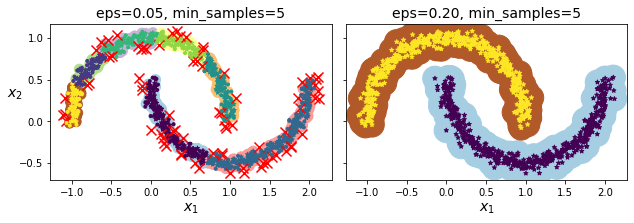

In [96]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

save_fig("[9-14] dbscan_plot")
plt.show()

이 알고리즘은 새로운 샘플에 대해 클러스터를 예측할 수 없음(fit_predict()만 제공)

이런 구현결정은 다른 분류 알고리즘이 이런 작업을 더 잘 수행할 수 있기 때문.

따라서 사용자가 필요한 예측기를 선택해야 함. 구현하는 것도 그리 어렵지 않음.

In [97]:
dbscan = dbscan2

In [98]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(n_neighbors=50)

In [99]:
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

array([1, 0, 1, 0], dtype=int64)

In [100]:
knn.predict_proba(X_new)

array([[0.18, 0.82],
       [1.  , 0.  ],
       [0.12, 0.88],
       [1.  , 0.  ]])

이 분류기를 핵심 샘플에서만 훈련했지만 모든 샘플에서 훈련할 수도 있음.

또는 이상치를 제외하는 것도 가능함. 선택은 최종작업에서 결정됨.

|

이 결정경계가 [9-15]에 나타나 있음. ('+'기호는 X_new에 있는 샘플 4개를 표시)

훈련세트에 이상치가 없기에 클러스터가 멀리 떨어져 있더라도 분류기는 항상 클러스터 한 개를 선택.

최대거리를 사용하면 두 클러스터에서 멀리 떨어진 샘플을 이상치로 분류할 수 있음.

그림 저장: [9-15] cluster_classification_plot


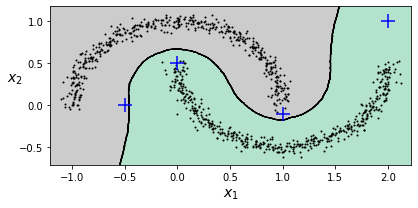

In [101]:
plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)
save_fig("[9-15] cluster_classification_plot")
plt.show()

KNeighborsClassifier의 kneighbors()를 사용해 전달하면 훈련세트에서 가장 가까운 k개 이웃의 거리와 인덱스를 반환함. (k개 열을 가진 행렬 2개를 반환함)

In [102]:
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1
y_pred.ravel()

array([-1,  0,  1, -1], dtype=int64)

DBSCAN은 간단하지만 강력한 알고리즘. 클러스터의 모양과 개수에 상관없이 감지.

이상치에 안정적이고 하이퍼파라미터가 2개뿐임(eps와 min_samples).

하지만 클러스터 간의 밀집도가 크게 다르면 모든 클러스터를 올바르게 잡아내는 것이 불가능.

계산복잡도 : $O(m\log m)$. 샘플개수에 선형적으로 증가. 

사이킷런의 구현은 eps가 커지면 $O(m^2)$만큼 메모리가 필요

#### TIP

scikit-learn-contrib 프로젝트에 구현된 계층적 DBSCAN(HDBSCAN)도 실험해볼 것

### 다른 군집 알고리즘

* 병합 군집: 클러스터 계층을 밑바닥부터 위로 쌓아 구성, 
반복마다 병합 군집은 인접한 클러스터 쌍을 연결. 대규모 샘플과 클러스터에 잘 확장, 다양한 형태의 클러스터를 감지, 특정 클러스터 개수를 선택하는데 도움이 되는 클러스터 트리를 만들 수 있다. 연결 행렬이 없으면 대규모 데이터셋으로 확장이 어렵다.

* BIRCH: 대규모 데이터셋을 위해 고안. 훈련 과정에서 새로운 샘플을 클러스터에 빠르게 할당할 수 있는 정보를 담은 트리 구조 생성. 제한된 메모리를 사용해 대용량 데이터셋 사용

* 평균-이동: 각 샘플을 중심으로 하는 원을 그리고 각 원마다 포함된 모든 샘플의 평균을 구한 뒤 원의 중심을 평균점으로 이동. 원이 움직이지 않을 때까지 반복. 지역의 최대 밀도를 찾아 원을 이동. 모양이나 개수에 상관없이 클러스터를 차아내고 하이퍼파라미터도 적다. DBSCAN과 달리 클러스터 내부 밀집도가 불균형할 때 여러 개로 나누는 경향이 있으며 계산 복잡도는 $O(m^2)$

* 유사도 전파: 투표 방식 사용. 각 샘플이 자신을 대표할 수 있는 비슷한 샘플에 투표하여 각 대표와 투표한 샘플이 클러스터를 형성. 크기가 다른 여러 개의 클러스터를 감지. 계산 복잡도 $O(m^2)$

* 스펙트럼 군집: 샘플 사이의 유사도 행렬을 받아 저차원 임베딩을 생성, 저차원 공간에서 또 다른 군집 알고리즘을 사용. 복잡한 클러스터 구조를 감지하고 그래프 컷을 찾는데 사용 가능. 샘플 개수가 많으면 잘 적용되지 않고 클러스터의 크기가 매우 다르면 잘 작동하지 않음.

## 가우시안 혼합 (GMM)

샘플이 파라미터가 알려지지 않은 여러 개의 혼합된 가우시안 분포에서 생성되었다고 가정하는 확률모델.

여러 GMM 변종이 있음. 가장 간단한 버전이 GaussianMixture 클래스에 구현됨.

데이터셋 X가 다음 확률 과정을 통해 생성되었다고 가정.

1. 샘플마다 k개의 클러스터에서 랜점하게 한 클러스터가 선택. j번째 클러서터를 선택할 확률은 클러스터의 가중치 $\phi^{(i)}$로 정의의. i번째 샘플을 위ㅟ해 선택한 클러스터 인덱스는 $z^{(i)}$ 로 표시

2. $z^{(i)}=j$(i번째 샘플이 j번째 클러스터에 할당)이면 이 샘플의 위치 $x^{(i)}$ 는 평균이 $\mu^{(i)} $ 이고 공분산 행렬이 $\sum\limits{(i)}$ 인 가우시안 분포에서 랜덤하게 샘플링됨. 이를
$x^{(i)}- N(\mu^{(i)}, \sum\limits{(i)})$와 같이 씀.

이 생성 과정을 그래프 모형으로 나타낼 수 있음. 확률변수 사이의 조건부 의존성의 구조를 나타냄

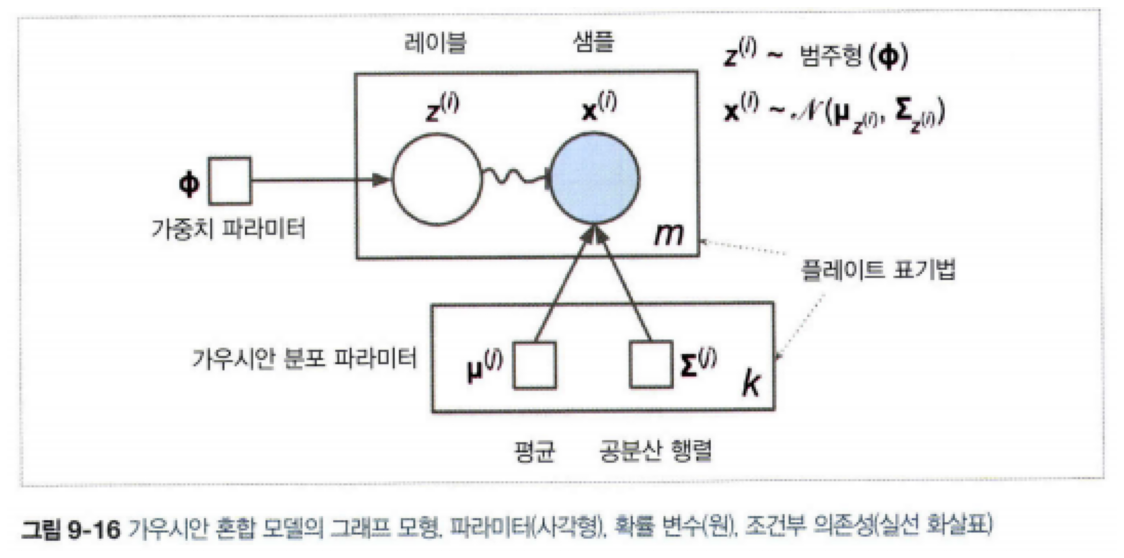

In [103]:
import matplotlib.image as mpimg

filename = "UnSL11.png"
images_path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
show_img = mpimg.imread(os.path.join(images_path, filename))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.imshow(show_img)

* 원은 확률 변수

* 사각형은 고정값(모델의 파라미터)

* 큰 사각형은 플레이트. 안의 내용이 여러번 반복
  각 플레이트 오른쪽 아래 숫자는 안의 내용이 얼마나 반복되는지 표현.

* 각 변수 $z^{(i)}$ 는 가중치 $\phi$ 를 갖는 범주형 분포에서 샘플링. 각 변수 $x^{(i)}$ 는 
  해당하는 클러스터 $z^{(i)}$ 로 정의된 평균과 공분산 행렬을 사용해 정규분포에서 샘플링

* 실선 화살표는 조건부 의존성을 표현. 화살표가 플레이트 경계를 가로지르면 해당 플레이트의 모든 반복에   
  적용

* $z^{(i)}$ 에서 $x^{(i)}$ 까지 구불구불한 화살표는 스위치. $z^{(i)}$ 의 값에 따라 샘플 
  $x^{(i)}$ 가 다른 가우시안 분포에서 샘플링

* 색이 채워진 원은 알려진 값(관측 변수, 알려지지 않은 값은 잠재 변수)

이 모델로 무엇을 할 수 있을까? 먼저 데이터셋 X가 주어지면 가중치 $\phi$ 와 

전체분포의 파라미터 $\mu^{(i)}$ 에서 $\mu^{(k)}$ 까지와 $\sum\limits{(i)}$ 에서 $\sum\limits{(k)}$ 까지를 추정.

사이킷런의 GaussianMixture를 사용하면 아주 쉬움.

In [104]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

In [105]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

GaussianMixture(n_components=3, n_init=10, random_state=42)

알고리즘이 추정한 파라미터 추정

In [106]:
gm.weights_

array([0.39025715, 0.40007391, 0.20966893])

In [107]:
gm.means_

array([[ 0.05131611,  0.07521837],
       [-1.40763156,  1.42708225],
       [ 3.39893794,  1.05928897]])

In [108]:
gm.covariances_

array([[[ 0.68799922,  0.79606357],
        [ 0.79606357,  1.21236106]],

       [[ 0.63479409,  0.72970799],
        [ 0.72970799,  1.1610351 ]],

       [[ 1.14833585, -0.03256179],
        [-0.03256179,  0.95490931]]])

이 클래스는 기댓값-최대화(EM)를 사용함.

#### 기댓값-최대화 알고리즘 (EM) 

샘플을 각 클러스터에 속할 확률을 예측하여 클러스터에 할당(기댓값 단계), 

데이터 셋에 있는 모든 샘플을 사용하여 클러스터를 업데이트(최대화 단계). 

k-means와 다르게 소프트 클러스터 할당을 사용.

#### CAUTION_

아쉽지만 k-평균처럼 EM이 나쁜 솔루션으로 수렴할 수 있음.

따라서 n_init을 10으로 설정. (default는 1이기 때문에 유의해야함)

이 알고리즘이 실제 수렴여부와 반복 횟수 확인

In [109]:
print("[-] 수렴 여부 : ", gm.converged_)
print("[-] 반복 횟수 : ", gm.n_iter_)

[-] 수렴 여부 :  True
[-] 반복 횟수 :  4


이제 이 모델을 사용해 각 샘플이 속한 클러스터(하드 군집)나 클러스터에 속할 확률(소프트군집)을 예측할 수 있습니다. 이를 위해 `predict()` 메서드나 `predict_proba()` 메서드를 사용합니다:

In [110]:
gm.predict(X)

array([0, 0, 1, ..., 2, 2, 2], dtype=int64)

In [111]:
gm.predict_proba(X)

array([[9.76741808e-01, 6.78581203e-07, 2.32575136e-02],
       [9.82832955e-01, 6.76173663e-04, 1.64908714e-02],
       [7.46494398e-05, 9.99923327e-01, 2.02398402e-06],
       ...,
       [4.26050456e-07, 2.15512941e-26, 9.99999574e-01],
       [5.04987704e-16, 1.48083217e-41, 1.00000000e+00],
       [2.24602826e-15, 8.11457779e-41, 1.00000000e+00]])

가우시안 혼합 모델은 생성 모델. 즉 이 모델에서 새로운 샘플을 만들 수 있음.

(반환된 샘플은 클러스터 인덱스 순으로 정렬되어 있음)

In [112]:
X_new, y_new = gm.sample(6)
X_new

array([[-0.86944074, -0.32767626],
       [ 0.29836051,  0.28297011],
       [-2.8014927 , -0.09047309],
       [ 3.98203732,  1.49951491],
       [ 3.81677148,  0.53095244],
       [ 2.84104923, -0.73858639]])

In [113]:
y_new

array([0, 0, 1, 2, 2, 2])

각 클러스터에서 순서대로 샘플링되었습니다.

`score_samples()` 메서드를 사용해 확률밀도함수(PDF)의 로그를 예측, 점수 높을수록 밀도가 높음

In [114]:
gm.score_samples(X)

array([-2.60768954, -3.57110232, -3.32987086, ..., -3.51347241,
       -4.39798588, -3.80746532])

이 점수의 지숫값을 계산하면 샘플의 위치에서 PDF 값을 얻을 수 있음.

이 값은 하나의 확률이 아닌 밀도. 즉 0~1 값이 아닌 양수값도 될 수 있음.

샘플이 특정 지역 안에 속할 확률을 예측하려면 그 지역에 대해 PDF를 적분해야함.

(가능한 샘플 위치 전 지역에 대해 적분해 더하면 1이 됨.)

전체 공간에 대해 이 PDF를 적분하면 1이 되는지 확인해 보죠. 클러스터 주위로 큰 사각형을 정하고 작은 사각형의 그리드로 자릅니다. 그다음 작은 사각형에서 샘플이 생성될 확률의 근삿값을 계산해 보죠(작은 사각형의 면적과 PDF를 곱하고 이 확률을 모두 더합니다). 결괏값은 1에 매우 가깝습니다:

[9-17]은 이 모델의 클러스터 평균, 결정경계(파선), 밀도 등고선을 보여줌.

In [115]:
resolution = 100
grid = np.arange(-10, 10, 1 / resolution)
xx, yy = np.meshgrid(grid, grid)
X_full = np.vstack([xx.ravel(), yy.ravel()]).T

pdf = np.exp(gm.score_samples(X_full))
pdf_probas = pdf * (1 / resolution) ** 2
pdf_probas.sum()

0.9999999999215021

In [116]:
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

그림 저장: [9-17] gaussian_mixtures_plot


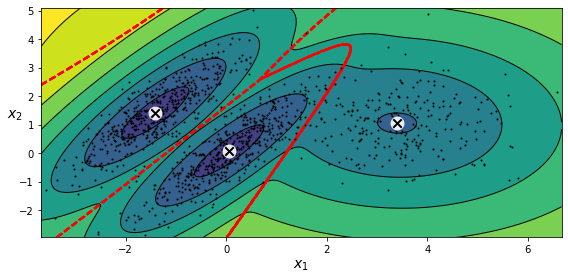

In [117]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)

save_fig("[9-17] gaussian_mixtures_plot")
plt.show()

알로리즘이 훌륭한 솔루션을 찾은 것 같다. 물론 이 문제는 2D 가우시안 분포를 사용해 

데이터를 생성한 쉬운 작업(실제데이터는 가우시안 분포나 저차원이 아닌 경우가 많음).

또한 이 알고리즘에 정확한 클러스터 개수를 입력함. 특성이나 클러스터가 많거나 

샘플이 적을 때는 EM이 최적의 솔루션으로 수렴하기 어려움.

=> 학습할 파라미터 수 제한, covariance_type를 사용하면 됨

`covariance_type` 매개변수를 사용해 이 알고리즘이 찾을 공분산 행렬을 제한할 수 있습니다.
* `"full"`(기본값): 제약이 없습니다. 모든 클러스터가 어떤 크기의 타원도 될 수 있습니다.
* `"tied"`: 모든 클러스터가 동일하지만 어떤 타원도 가능합니다(즉, 공분산 행렬을 공유합니다).
* `"spherical"`: 모든 클러스터가 원형이지만 지름은 다를 수 있습니다(즉, 분산이 다릅니다).
* `"diag"`: 클러스터는 어떤 크기의 타원도 될 수 있지만 타원은 축에 나란해야 합니다(즉, 공분산 행렬이 대각 행렬입니다).

In [118]:
gm_full = GaussianMixture(n_components=3, n_init=10, covariance_type="full", random_state=42)
gm_tied = GaussianMixture(n_components=3, n_init=10, covariance_type="tied", random_state=42)
gm_spherical = GaussianMixture(n_components=3, n_init=10, covariance_type="spherical", random_state=42)
gm_diag = GaussianMixture(n_components=3, n_init=10, covariance_type="diag", random_state=42)
gm_full.fit(X)
gm_tied.fit(X)
gm_spherical.fit(X)
gm_diag.fit(X)

GaussianMixture(covariance_type='diag', n_components=3, n_init=10,
                random_state=42)

In [119]:
def compare_gaussian_mixtures(gm1, gm2, X):
    plt.figure(figsize=(9, 4))

    plt.subplot(121)
    plot_gaussian_mixture(gm1, X)
    plt.title('covariance_type="{}"'.format(gm1.covariance_type), fontsize=14)

    plt.subplot(122)
    plot_gaussian_mixture(gm2, X, show_ylabels=False)
    plt.title('covariance_type="{}"'.format(gm2.covariance_type), fontsize=14)


그림 저장: covariance_type_plot


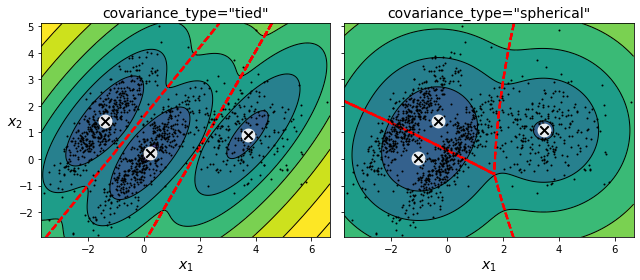

In [120]:
compare_gaussian_mixtures(gm_tied, gm_spherical, X)

save_fig("covariance_type_plot")
plt.show()

GaussianMixture 모델을 훈련하는 계산복잡도는 공분산 행렬에 있는 제약에 따라 결정.

"spherical"나 "diag"이면 데이터에 어떤 클러스터 구조가 있다고 가정하므로 $O(kmn)$.

"tied"나 "full"이면 $O(kmn^2+kn^2)$ => 특성 수가 많으면 적용 어려움.

### 가우시안 혼합을 사용한 이상치 탐지

* 사용할 밀도 임계값을 정하여 밀도가 낮은 지역에 있는 모든 샘플을 이상치로 가정
* 깨끗한 데이터셋에서 특이치 탐지로 사용도 가능

예로 결함제품의 비율을 4%라고 가정. 밀도임곗값을 이 값으로 설정하면 밀도가 낮은 지역에

있는 샘플의 4%를 얻을 수 있음. 만약 거짓 양성이 많다면 임곗값을 더 낮춤.

반대로 거짓 음성이 너무 많다면 임곗값을 더 높임 -> 정밀도/트레이드오프(3장 참조).

네 번째 백분위수(4%)를 밀도임곗값으로 사용해 이상치를 구분하는 방법을 보여줌.

In [121]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 4)
anomalies = X[densities < density_threshold]

이상치는 별모양으로 표시되어 있음.

그림 저장: mixture_anomaly_detection_plot


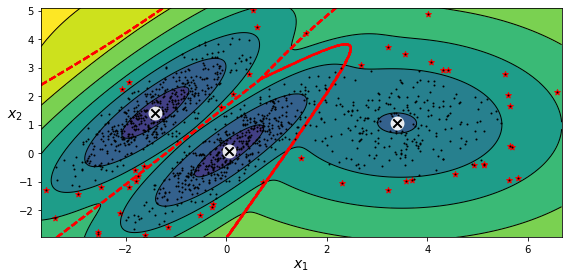

In [122]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)

save_fig("mixture_anomaly_detection_plot")
plt.show()

이와 비슷한 작업은 특이치 탐지. 이 알고리즘은 이상치로 오염되지 않은 

'깨끗한' 데이터셋에서 훈련한다는 것이 이상치탐지와 다름. 실제로 이상치 탐지는 데이터셋 정제에 주로 사용.

#### TIP

가우시안 혼합 모델은 이상치를 포함한 모든 데이터에 맞추려 함. 따라서 이상치가 너무 많으면 일부 이상치를 정상으로 생각할 수 있음. 이를 방지하기 위해 이상치를 제거함. 그다음 정제된 데이터셋에서 모델을 훈련하거나
안정적인 공분산 추정방법을 사용(EllopticEnvelope 참고).

### 클러스터 개수 선택하기

가우시안 알고리즘은 k-평균처럼 클러스터 수를 지정해야 함.

k-평균에선 이너셔나 실루엣 점수를 사용해 적절한 클러스터 수를 선택.

가우시안에선 안 됨(클러스터가 타원형이거나 크기가 다를 때 안정적이지 않기 때문).

대신 정의된 **BIC**나 **AIC**와 같은 이론적 정보 기준을 최소화하는 모델을 찾음.

${BIC} = {\log(m)p - 2\log({\hat L})}$

${AIC} = 2p - 2\log(\hat L)$

* $m$은 샘플의 개수입니다.
* $p$는 모델이 학습할 파라미터 개수입니다.
* $\hat L$은 모델의 가능도 함수의 최댓값입니다. 이는 모델과 최적의 파라미터가 주어졌을 때 관측 데이터 $\mathbf{X}$의 조건부 확률입니다.

BIC와 AIC 모두 모델이 많은 파라미터(예를 들면 많은 클러스터)를 학습하지 못하도록 제한. 그리고 데이터에 잘 맞는 모델(즉, 관측 데이터에 가능도가 높은 모델)에 보상을 줌.

In [123]:
gm.bic(X)

8189.747000497186

In [124]:
gm.aic(X)

8102.521720382148

다음과 같이 BIC를 수동으로 계산가능:

In [125]:
n_clusters = 3
n_dims = 2
n_params_for_weights = n_clusters - 1
n_params_for_means = n_clusters * n_dims
n_params_for_covariance = n_clusters * n_dims * (n_dims + 1) // 2
n_params = n_params_for_weights + n_params_for_means + n_params_for_covariance
max_log_likelihood = gm.score(X) * len(X) # log(L^)
bic = np.log(len(X)) * n_params - 2 * max_log_likelihood
aic = 2 * n_params - 2 * max_log_likelihood

In [126]:
print("[=] BIC : {0}\n[=] AIC : {1}".format(bic, aic))

[=] BIC : 8189.747000497186
[=] AIC : 8102.521720382148


In [127]:
n_params

17

클러스터마다 하나의 가중치가 있지만 모두 더하면 1이 되어야 합니다. 따라서 자유도는 1이 줄어듭니다. 비슷하게 $n \times n$ 공분산 행렬의 자유도는 $n^2$가 아니라 $1 + 2 + \dots + n = \dfrac{n (n+1)}{2}$입니다.

여러 가지 $k$ 값에 대해 가우시안 혼합 모델을 훈련하고 BIC를 측정해 보죠:

In [128]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 11)]

bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows wi

[9-21]은 여러가지 클러스터 개수 k에 대한 AIC와 BIC를 보여줌.

여기서 볼 수 있듯이 k=3이 최선의 선택으로 보임. covariance_type 매개변수에 대해 

최선의 값을 탐색할 수도 있음. ex. "full"대신 "spherical"을 선택하면 학습할 파라미터가 크게 줄어듦.

하지만 데이터에 잘 맞지 않음.

그림 저장: [9-21] aic_bic_vs_k_plot


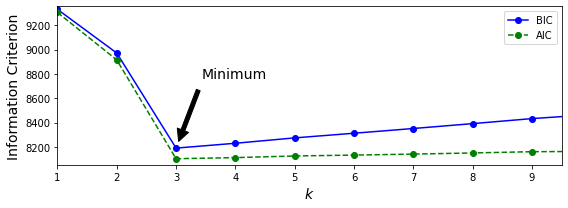

In [129]:
plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])
plt.annotate('Minimum',
             xy=(3, bics[2]),
             xytext=(0.35, 0.6),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.legend()
save_fig("[9-21] aic_bic_vs_k_plot")
plt.show()

클러스터 개수와 `covariance_type` 하이퍼파라미터의 최적 조합을 찾아 보겠습니다:

In [130]:
min_bic = np.infty

for k in range(1, 11):
    for covariance_type in ("full", "tied", "spherical", "diag"):
        bic = GaussianMixture(n_components=k, n_init=10,
                              covariance_type=covariance_type,
                              random_state=42).fit(X).bic(X)
        if bic < min_bic:
            min_bic = bic
            best_k = k
            best_covariance_type = covariance_type

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows wi

In [131]:
best_k

3

In [132]:
best_covariance_type

'full'

### 베이즈 가우시안 혼합 모델

* 최적의 클러스터 개수를 수동으로 찾지 않고 불필요한 클러스터의 가중치를 0또는 0에 가깝게 만드는 방법

* 클러스터 개수 n_componets를 최적의 클러스터 개수보다 크다고 믿을 만한 값을 지정하고 불필요한 
  클러스터를 제거하는 방법

최적의 클러스터 수를 수동으로 찾지 않고 불필요한 클러스터의 가중치를 0으로 만드는

BayesianGaussianMixture 클래스를 사용할 수 있음. 클러스터 수 n_components를 

최적의 클러스터 수보다 크다고 믿을 만한 값으로 지정. (현재문제에 대한 최소한의 정보를 갖고 있다고 가정)

이 알고리즘은 자동으로 불필요한 클러스터를 제거. 클러스터 개수 10개로 지정하고 결과확인

In [133]:
from sklearn.mixture import BayesianGaussianMixture

bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X)

BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)

알고리즘이 자동으로 3개의 컴포넌트가 필요하다는 것을 감지했습니다:

In [134]:
np.round(bgm.weights_, 2)

array([0.4 , 0.21, 0.4 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

* 클러스터 파라미터(가중치, 평균, 공분산 행렬 등)는 고정된 모델 파라미터가 아닌 클러스터 할당처럼 잠재 
  확률변수로 취급됨. 따라서 이제 z는 클러스터 파라미터와 클러스터 할당을 모두 포함.

* 베타분포: a 와 b라는 두 모수를 가지며 표본 공간은 0과 1사이의 실수다. 즉 0과 1 사이의 표본값만 
  가질 수 있다. 고정 범위 안에 놓인 값을 가진 확률 변수를 모델링 할 때 자주 사용. 

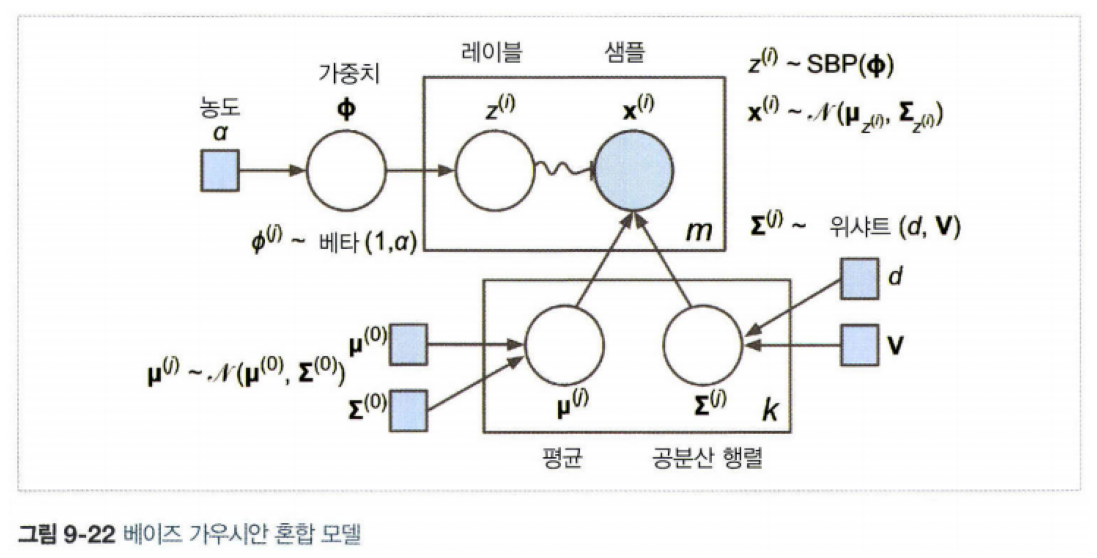

In [135]:
filename = "UnSL16.png"
images_path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
show_img = mpimg.imread(os.path.join(images_path, filename))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.imshow(show_img)

잠재 변수 z에 대한 사전지식이 사전확률이라는 확률분포 p(z)에 인코딩될 수 있음.

예를 들어 클러스터가 적을 것이라는 사전믿음(낮은 농도)를 가질 수 있음.

반대로(높은 농도) 믿을 수도 있음. 이런 클러스터 개수에 대한 사전 믿음은 

weight_concentration_prior 매개변수를 사용해 조정가능함. 이를 0.01 또는 10,000으로

지정하면 매우 다른 군집 결과를 만듦. 하지만 데이터가 많을수록 사전 믿음은 중요하지 않음.

사실 이렇게 큰 차이가 나는 그래프를 그리려면 사전믿음이 매우 강하고 데이터는 적어야 함.

베이즈 정리는 (9-2)는 데이터 X를 관측하고 난 후 잠재변수에 대한 확률분포를 업데이트하는 방법을 설명.

이는 X가 주어졌을 때 z의 조거눕 확률인 사후확률분포 p(z|X)을 계산함.

**9-2 베이즈 정리**

$
p(z|X)= \text{사후확률} = \frac{\text{가능도} \times \text{사전 확률}}{\text{증거}}=\frac{p(X|z)p(z)}{p(X)}
$

안타깝지만 가우시안 혼합모델에서 분모인 $p(X)$ 는 계산하기 힘듦. 가능한 모든 z값에 대해 적분해야하기 때문(9-3). 모든 클러스터 파라미터와 클러스터 할당의 조합을 고려해야 함.

**9-3 p(X)는 구하기 어려움**

$
p(X)=\int p(X|z)p(z)dz
$

이것이 베이즈 통계학에 있는 주요 문제. 이를 해결하기 위한 몇가지 방법이 존재.

그중하나는 변분추론. 이 방식은 자체적인 변분 파라미터 $\lambda$ 를 가진 분포 패밀리 $q(z;\lambda)$ 를선택. 

그다음 $q(z)$ 가 $p(z|X)$ 의 좋은 근삿값이 되도록 이 파라미터를 최적화함.

$q(z)$에서 $p(z|X)$로의 KL발산(${D_{KL}(q||p)}$라고 씀)을 최소화하는 $\lambda$ 값을 찾아 이를 해결.

이 KL(쿨백-라이블러)발산 공식은 (9-4)에 나타나 있음.

이 식은 증거의 로그 ($\log p(X)$)에서 증거하한(ELBO)을 뺀 식으로 다시 쓸 수 있음.

증거의 로그는 q에 의존하지 않고 상수항이므로 KL발산을 최소화하려면 ELBO를 최소화해야 함.

**9-4 q(z)에서 p(z)로의 KL발산**

$
{D_{KL}(q||p)}= \log p(X) - ELBO
$

$\text{여기에서} \quad ELBO = \boldsymbol{E_q}[\log p({z,X})] - \boldsymbol{E_q}[\log q({z})] 
$

실전에서는 다른 기법으로 ELBO를 최대화함. 평균장 변분 추론에서 ELBO 식을 계산할 수 있는 형태로 단순화하기 위해 분포 패밀리 $q(z;\lambda)$와 사전확률 $p(z)$ 를 매우 주의깊게 선택해야함.

아쉽게도 이를 위한 일반적인 방법이 없음. 올바른 분포 패밀리 사전 확률을 선택하는 것은 작업에
따라 다르면 수학적 기술이 필요. 예로 사이킷런의 BayesianGaussianMixture 클래스에서
사용하는 분포와 하한식은 온라인 문서(https://homl.info/40)참고.

그다음 기댓값-최대화 알고리즘에서 매우 비슷하게 사용됨.
사실 BayesianGaussianMixture 클래스의 계산복잡도 GaussianMixture 클래스의 복잡도와 비슷.
ELBO를 최대화하는 간단한 방법은 블랙박스 확률적 변분 추론(BBSVI).

각 반복에서 몇 개의 샘플을 q에서 뽑아 변분 파라미터 $\lambda$ 에 대한 ELBO의 그레디언트를 추정하는데 사용함.

이 방법은(미분가능하다면) 어떤 종류의 모델과도 베이즈 추론을 사용할 수 있게 만듦.
심지어 심층신경망도 가능. 심층신경망에 사용하는 베이즈추론을 베이즈딥러닝이라고 부름.

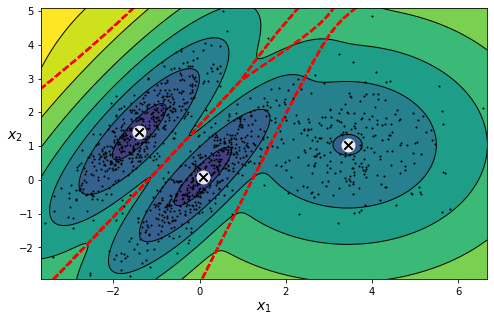

In [136]:
plt.figure(figsize=(8, 5))
plot_gaussian_mixture(bgm, X)
plt.show()

In [137]:
bgm_low = BayesianGaussianMixture(n_components=10, max_iter=1000, n_init=1,
                                  weight_concentration_prior=0.01, random_state=42)
bgm_high = BayesianGaussianMixture(n_components=10, max_iter=1000, n_init=1,
                                  weight_concentration_prior=10000, random_state=42)
nn = 73
bgm_low.fit(X[:nn])
bgm_high.fit(X[:nn])

BayesianGaussianMixture(max_iter=1000, n_components=10, random_state=42,
                        weight_concentration_prior=10000)

In [138]:
np.round(bgm_low.weights_, 2)

array([0.52, 0.48, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

In [139]:
np.round(bgm_high.weights_, 2)

array([0.01, 0.18, 0.27, 0.11, 0.01, 0.01, 0.01, 0.01, 0.37, 0.01])

그림 저장: mixture_concentration_prior_plot


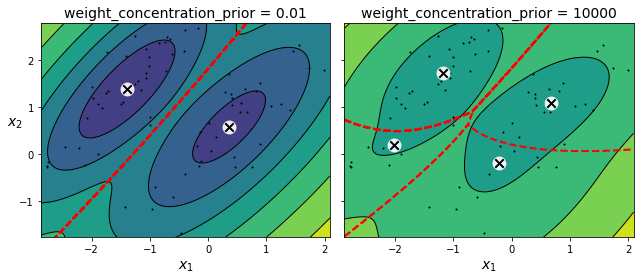

In [140]:
plt.figure(figsize=(9, 4))

plt.subplot(121)
plot_gaussian_mixture(bgm_low, X[:nn])
plt.title("weight_concentration_prior = 0.01", fontsize=14)

plt.subplot(122)
plot_gaussian_mixture(bgm_high, X[:nn], show_ylabels=False)
plt.title("weight_concentration_prior = 10000", fontsize=14)

save_fig("mixture_concentration_prior_plot")
plt.show()

타원형 클러스터에 잘 작동하나 다른 모양을 가진 데이터셋에는 좋지 못하다.

In [141]:
X_moons, y_moons = make_moons(n_samples=1000, noise=0.05, random_state=42)

In [142]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X_moons)

BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)

그림 저장: moons_vs_bgm_plot


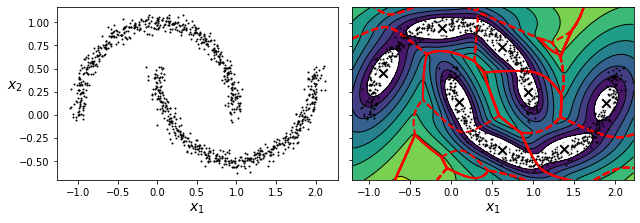

In [143]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_data(X_moons)
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14, rotation=0)

plt.subplot(122)
plot_gaussian_mixture(bgm, X_moons, show_ylabels=False)

save_fig("moons_vs_bgm_plot")
plt.show()

이 알고리즘은 필사적으로 타원을 찾음. 2개가 아닌 8개의 클러스터를 찾음.
밀도추정은 너무 나쁘지 않으므로 이 모델은 이상치를 감지하기 위해 사용할 수 있을 것.

하지만 2개의 반달모양 인식 실패.

이런 좋지 않군요. 반달 모양 클러스터 2개를 감지하는 대신 이 알고리즘은 8개의 타원 클러스터를 감지했습니다. 하지만 밀도 그래프는 그렇게 나쁘지 않기 때문에 이상치 탐지에 사용할 수 있습니다.

### 이상치 탐지와 특이치 탐지를 위한 다른 알고리즘

* PCA(그리고 inverse_transform() 메서드를 가진 다른 차원 축소 기법): 샘플의 재구성 오차와 이상치의 
  재수겅 오차를 비교하면 일반적으로 후자가 크다. 이를 이용하여 이상치 탐지

* Fast-MCD(minimum covariance determinant): EllipticEnvelope 클래스에서 구현. 데이터셋을 정제할 때 
  사용. 샘플(정상치)가 하나의 가우시안 분포에서 생성되었다고 가정하고 이 가우시안 분포에서 생성되지 않은 이상치로 이 데이터셋이 오염되었다고 가정. 가우시안 분포의 파라미터를 추정할 때 이상치로 의심되는 샘플을 무시

* 아이솔레이션 포레스트: 고차원 데이터셋에서 이상치 감지를 위한 알고리즘. 무작위로 성장한 결정 트리로 
  구성된 랜덤 포레스트 생성. 모든 샘플이 다른 샘플과 격리될 때까지 진행하고 다른 샘플과 멀리 떨어져있는 샘플을 이상치로 판단. 평균적으로 정상 샘플과 적은 단계에서 격리

* LOF(local outlier factor): 주어진 샘플 주위의 밀도와 이웃 주위의 밀도를 비교

* one-class SVM: 특이치 탐지에 사용. SVM이지만 클래스가 하나. 원본 공간으로부터 고차원 공간에 있는 
  샘플을 분리(원본 공간에서는 모든 샘플을 둘러싼 작은 영역을 찾는 것). 새로운 샘플이 이 영역 안에 놓이지 않는 다면 이는 이상. 고차원 데이터셋에 잘 작동하나 대규모 데이터셋으로 확장은 어렵다.